# Thermodynamic-to-Antenna Temperature Conversion

The incoming flux from the CMB is usually described in temperature units because CMB is near-perfect blackbody and a single temperature uniquely specifies its intensity at any wavelength.

This notebook will use the function `t2a_table_factor` to calculate the thermodynamic\-to\-antenna temperature conversion factors for WMAP and CLASS frequency bands.
This conversion factor is applied to WMAP and CLASS maps to facilitate the cross band/experiment comparison for astrophysical sources with non\-CMB spectra.

We will begin by explaining the formula used in CLASS analysis, then show few examples on how the `t2a_table_factor` function is typically used. Detailed derivation of the conversion factor can be found after the examples.

---

## CLASS thermodynamic-to-antenna temperature conversion approximation

The relation between the thermodynamic and antenna temperature is
$$\tag{1}
T_A^*=T_C^*\cdot g(\nu_*) \cdot cc,$$
where $g(\nu_*)$ converts the unit from thermodynamic temperature to Rayleigh\-Jeans brightness temperature at frequency $\nu_*$, and $cc$ is the color correction factor. Usually $cc$ is used to correct from differential blackbody to SED of other astrophysical/cosmological sources.
The derivation for $g(\nu_*)$ and $cc$ can be found after the examples. Note that although $cc$ can be computed from the SED model and instrument bandpass, in practice people use empirical formulae to approximate the color correction factor.

CLASS approximates the conversion between the thermodynamic temperature assuming differential blackbody and the antenna temperature assuming other SED as Eq. \(E5\) in [arXiv:1212.5225](https://arxiv.org/abs/1212.5225) \(slightly modified to match with notations used in this document\):
$$\tag 2
T_C = \frac{1}{g(\nu_0)} \sum \limits_{i=1} ^{3} w_iT_A(\nu_i),$$

where the weights $w_{i}$ encode the shape of the bandpass function. This weighted sum is the Gaussian quadrature approximation to the actual bandpass integral and is accurate for sources with a smooth spectral shape over the band-pass. The frequencies $\nu_{i}$ are somewhat arbitrary and were chosen to even out the weights. $g(\nu_0)$ is a factor that concerns the thermodynamic to Rayleigh-Jeans unit conversion, and $\nu_0$ is different for different bands.

<table>
<tr>
    <th>Frequency Band</th>
    <th>$\nu_{1}$</th>
    <th>$\nu_{2}$</th>
    <th>$\nu_{3}$</th>
    <th>$w_{1}$</th> 
    <th>$w_{2}$</th>
    <th>$w_{3}$</th> 
    <th>$1/g(\nu_0)$</th> 
</tr>

<tr>
    <td>WMAP K Band</td> 
    <td>20.6</td> 
    <td>22.8</td>
    <td>24.9</td>
    <td>0.332906</td> 
    <td>0.374325</td> 
    <td>0.2927683</td>
    <td>1.013438</td>
</tr>

<tr>
    <td>WMAP Ka Band</td> 
    <td>30.4</td> 
    <td>33.0</td>
    <td>35.6</td>
    <td>0.322425</td> 
    <td>0.387532</td> 
    <td>0.290043</td>
    <td>1.028413</td>
</tr>
    
<tr>
    <td>WMAP Q Band</td> 
    <td>37.8</td> 
    <td>40.7</td>
    <td>43.8</td>
    <td>0.353635</td> 
    <td>0.342752</td> 
    <td>0.303613</td>
    <td>1.043500</td>
</tr>
    
<tr>
    <td>WMAP V Band</td> 
    <td>55.7</td> 
    <td>60.7</td>
    <td>66.2</td>
    <td>0.337805</td> 
    <td>0.370797</td> 
    <td>0.291399</td>
    <td>1.098986</td>
</tr>

<tr>
    <td>WMAP W Band</td> 
    <td>87.0</td> 
    <td>93.5</td>
    <td>100.8</td>
    <td>0.337633</td> 
    <td>0.367513</td> 
    <td>0.294854</td>
    <td>1.247521</td>
</tr>    
  
<tr>
    <td>CLASS 40 GHz</td> 
    <td>33.9</td> 
    <td>38.0</td>
    <td>42.1</td>
    <td>0.3060</td> 
    <td>0.3448</td> 
    <td>0.3491</td>
    <td>1.038</td>
</tr>  

Assuming power law SED $I_\nu\propto \nu^\alpha$ (or $T_A\propto \nu^\beta$, $\beta=\alpha-2$), Eq. (2) can be expanded as
$$
\begin{aligned}
T_C &= \frac{1}{g(\nu_0)} \sum \limits_{i=1} ^{3} w_iT_A^*\left(\frac{\nu_i}{\nu_*}\right)^\beta\\
&= T_A^* \frac{1}{g(\nu_0)}\sum \limits_{i=1} ^{3} w_i\left(\frac{\nu_i}{\nu_*}\right)^\beta
\end{aligned}
$$
Hence
$$
\tag{3}
T_A^* = T_C \cdot g(\nu_0) \cdot \frac{1}{\sum \limits_{i=1} ^{3} w_i\left(\frac{\nu_i}{\nu_*}\right)^\beta}
$$
Comparing to Eq. (1), we can see that $g(\nu_0)$ concerns the unit conversion. The color correction factor:
$$
\begin{aligned}
cc&=\frac{1}{\sum \limits_{i=1} ^{3} w_i\left(\frac{\nu_i}{\nu_*}\right)^\beta}\\
&=\frac{\nu_*^\beta}{\sum \limits_{i=1} ^{3} w_i\nu_i^\beta}
\end{aligned}
$$

---

## Codes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def t2a_table_factor(band, beta, nu=None, returnfreq=False):
    '''
    The thermodynamic-to-antenna (t2a) factor is a multiplicative factor
    to be applied to the maps in thermodynamic temperature to convert them 
    to antenna temperature at frequency nu following Equation E5 in arXiv:1212.5225.
    
    Interpolation data used for WMAP is from Table 20 in arXiv:1212.5225. 
    Note that this is equivalent to option==1 in fastcc (arXiv:2212.09488).

    Interpolation data used for CLASS is from Table 2 in arXiv:2309.00675.
    
    This function only supports power law SED model.
    
    Parameters
    ----------
    band: string
        This specifies the experiment and the band.
    beta : float or array
        The index of the power law SED.
    nu : float or array
        The frequency of the band, unit: GHz.
    returnfreq : bool
        If True, returns the frequency. Otherwise only the factor is returned.
    
    Return
    ------
    if returnfreq==True:
        returns frequency [GHz], thermodynamic-to-antenna factor
    else:
        returns thermodynamic-to-antenna factor
    '''
    Table = {
        'WK' : {'nu': [20.6, 22.8, 24.9], 'w': [0.332906, 0.374325, 0.292768], 'dT': 1.013438},
        'WKa': {'nu': [30.4, 33.0, 35.6], 'w': [0.322425, 0.387532, 0.290043], 'dT': 1.028413},
        'WQ' : {'nu': [37.8, 40.7, 43.8], 'w': [0.353635, 0.342752, 0.303613], 'dT': 1.043500},
        'WV' : {'nu': [55.7, 60.7, 66.2], 'w': [0.337805, 0.370797, 0.291399], 'dT': 1.098986},
        'WW' : {'nu': [87.0, 93.5, 100.8], 'w': [0.337633, 0.367513, 0.294854], 'dT': 1.247521},
        'C40' : {'nu': [33.9, 38.,  42.1], 'w': [0.3060, 0.3448, 0.3491], 'dT' : 1.038}
    }
    beta = np.atleast_1d(beta)
    w = np.array(Table[band]['w'])
    nus = np.array(Table[band]['nu'])
    if nu is None:
        nu = nus[1]
    nu = np.atleast_1d(nu)
    dt = 1 / Table[band]['dT']
    
    sum_term = np.sum( w * np.power(nus, beta[:, np.newaxis]), axis=1)
    if returnfreq:
        return nu, dt * np.power(nu, beta) / sum_term
    else:
        return dt * np.power(nu, beta) / sum_term

## Examples

### Ex. 1
If WMAP measured a source with thermodynamic temperature $10~\mathrm{mK_{CMB}}$ at K band, assuming the source SED is Rayleigh-Jeans spectrum ($I_\nu\propto \nu^2$, so the Rayleigh-Jeans temperature $T_A\propto \nu^0$, $T_A$ does not rely on $\nu$), what is the antenna temperature of the source at WMAP W band (assuming $90~\mathrm{GHz}$)?

In [3]:
# To get the thermodynamic-to-antenna conversion factor for WMAP K band, we set the parameter `band` to be `'WK'`.
# The SED is assumed to be Rayleigh-Jeans law, which means parameter `beta` need to be set to `0`.
# The question asks for the antenna temperature at 90 GHz, so parameter `nu` is set to `90`.

T_C = 10. # unit: mK_CMB
print(T_C * t2a_table_factor(band='WK', beta=0, nu=90))

[9.86741172]


The answer is $\sim 9.867~\mathrm{mK_{RJ}}$

### Ex. 2 
If WMAP measured a source with thermodynamic temperature $25~\mathrm{mK_{CMB}}$ at Ka band, assuming the source SED is a power law with spectral index $\beta=-3.1$ (i.e., Rayleigh-Jeans temperature $T_A\propto \nu^{-3.1}$), what is the antenna temperature of the source at WMAP V band (assuming $60~\mathrm{GHz}$)?

In [5]:
# To get the thermodynamic-to-antenna conversion factor for WMAP Ka band, we set the parameter `band` to be `'WKa'`.
# The SED is assumed to be power law with beta=-3.1, which means parameter `beta` need to be set to `-3.1`.
# The question asks for the antenna temperature at 60 GHz, so parameter `nu` is set to `60`.

T_C = 25. # unit: mK_CMB
print(T_C * t2a_table_factor(band='WKa', beta=-3.1, nu=60))

[3.68934311]


The answer is $\sim 3.689~\mathrm{mK_{RJ}}$.

### Ex. 3
Find the thermodynamic-to-antenna conversion factor for a power law spectrum with $\beta=-3.23$ measured at CLASS 40 GHz with center frequency $\nu$ = 37.56 GHz (this is used in Figure 10 of [arXiv:2309.00675](https://arxiv.org/abs/2309.00675)):

In [7]:
# To get the thermodynamic-to-antenna conversion factor for CLASS 40 GHz, we set the parameter `band` to be `'C40'`.
# The SED is assumed to be power law with beta=-3.23, which means parameter `beta` need to be set to `-3.23`.
# The question specifies a center frequency of 37.56 GHz, so parameter `nu` is set to `37.56`.

print(t2a_table_factor(band='C40', beta=-3.23, nu=37.56))

[0.9637007]


The answer is $\sim 0.964$.

### Observing Thermodynamic-to-Antenna Factors For CLASS 40 GHz Band

In [8]:
nu = np.linspace(35, 46)
# beta = -4.0
beta1 = t2a_table_factor(band='C40', beta=-4.0, nu=nu)
# beta = -3.5
beta2 = t2a_table_factor(band='C40', beta=-3.5, nu=nu)
# beta = -3.0
beta3 = t2a_table_factor(band='C40', beta=-3.0, nu=nu)
# beta = -2.5
beta4 = t2a_table_factor(band='C40', beta=-2.5, nu=nu)
# beta = -2.0
beta5 = t2a_table_factor(band='C40', beta=-2.0, nu=nu)

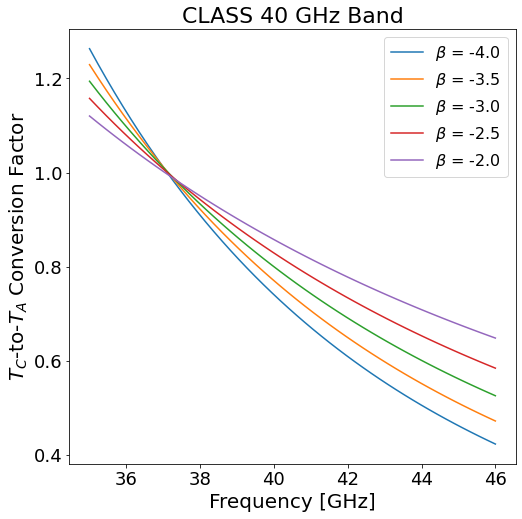

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(nu, beta1, label = r"$\beta$ = -4.0")
plt.plot(nu, beta2, label = r"$\beta$ = -3.5")
plt.plot(nu, beta3, label = r"$\beta$ = -3.0")
plt.plot(nu, beta4, label = r"$\beta$ = -2.5")
plt.plot(nu, beta5, label = r"$\beta$ = -2.0")
plt.title(r'CLASS 40 GHz Band', fontsize = 22)
plt.ylabel(r'$T_{C}$-to-$T_{A}$ Conversion Factor', fontsize = 20)
plt.xlabel(r'Frequency [GHz]', fontsize = 20)
plt.legend(fontsize = 16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

This figure considers both color correction and unit conversion. Each curve provides an array of multiplicative factor as a function of frequency. Apply that factor to find the antenna temperature for the corresponding $\beta$ and frequency.

In [10]:
betas = np.linspace(-4.0, -1.0)
# nu = -4.0
nu1 = t2a_table_factor(band='C40', beta=betas, nu=36)
# nu = -3.5
nu2 = t2a_table_factor(band='C40', beta=betas, nu=38)
# nu = -3.0
nu3 = t2a_table_factor(band='C40', beta=betas, nu=40)
# nu = -2.5
nu4 = t2a_table_factor(band='C40', beta=betas, nu=42)
# nu = -2.0
nu5 = t2a_table_factor(band='C40', beta=betas, nu=44)

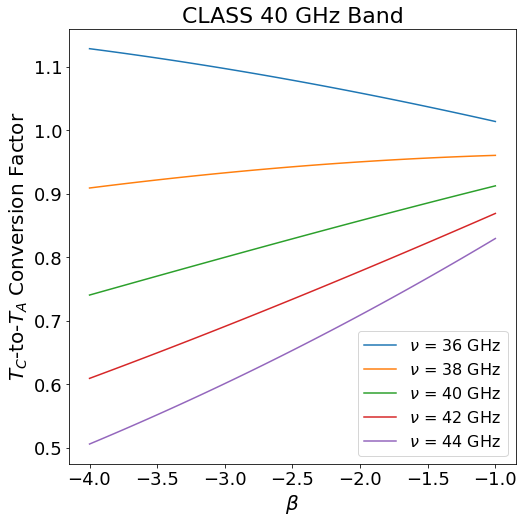

In [11]:
plt.figure(figsize=(8,8))
plt.plot(betas, nu1, label = r"$\nu$ = 36 GHz")
plt.plot(betas, nu2, label = r"$\nu$ = 38 GHz")
plt.plot(betas, nu3, label = r"$\nu$ = 40 GHz")
plt.plot(betas, nu4, label = r"$\nu$ = 42 GHz")
plt.plot(betas, nu5, label = r"$\nu$ = 44 GHz")
plt.title(r'CLASS 40 GHz Band', fontsize = 22)
plt.ylabel(r'$T_{C}$-to-$T_{A}$ Conversion Factor', fontsize = 20)
plt.xlabel(r'$\beta$', fontsize = 20)
plt.legend(fontsize = 16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

This figure considers both color correction and unit conversion. Each curve provides an array of multiplicative factor as a function of $\beta$. Apply that factor to find the antenna temperature for the corresponding $\beta$ and frequency.

---

## Derivation

The thermodynamic-to-antenna temperature conversion involves two aspects, unit conversion and color correction.

We will start by defining the commonly used temperatures.

#### Antenna Temperature

Assuming Rayleigh-Jeans law, the antenna temperature $T_A$ is equivalent to the Rayleigh-Jeans brightness temperature.
Most astrophysical foreground signals have a non-blackbody nature and are quantified in antenna temperature.
The specific intensity ($I_\nu$) following the Rayleigh-Jeans law is
$$
I_\nu=R_\nu(\nu, T_A)
$$
where 
- $R_\nu(\nu, T_A)=\dfrac{2\nu^2k_BT_A}{c^2}$ is the Rayleigh-Jeans law
- $\nu$ is the frequency where $I_\nu$ is estimated on
- $k_B$ is the Boltzmann constant
- $c$ is the speed of light

Therefore,
$$
T_A=\frac{c^2I_\nu}{2\nu^2k_B}
$$

#### Thermodynamic Temperature
Assuming blackbody spectrum, the specific intensity is
$$
I_\nu=B_\nu(\nu, T_C)
$$
where 
- $B_\nu(\nu, T_C)=\dfrac{2h\nu^3}{c^2}\dfrac{1}{e^{h\nu/k_BT_C}-1}$ is the blackbody spectrum (Planck's law)
- $h$ is the Planck constant
- $T_C$ refers to the thermodynamic temperature

Therefore,
$$
\begin{aligned}
\frac{h\nu}{k_BT_C}&=\log\left(1+\frac{2h\nu^3}{c^2I_\nu}\right)\\
\text{or,}~~T_C&=\frac{h\nu}{k_B\log\left(1+\frac{2h\nu^3}{c^2I_\nu}\right)}
\end{aligned}
$$

**NOTE**: temperature is a handy tool for describing the radiation intensity. But temperature 'changes' when assuming different spectra. For example, $T_A\neq T_C$ for the same $I_\nu$.

The power carried by the photons (characterized by the specific intensity), however, is the intrinsic physical quantity that won't change with the assumed spectra.

#### Differential Temperature 
Differential temperature has nothing to do with the SED, and is related to the fact that most recent CMB surveyors care about the temperature fluctuation (a.k.a. anisotropy) around the CMB monopole temperature ($T_\mathrm{CMB}\approx 2.726~\mathrm K$).

To define the differential temperature for thermodynamic and antenna temperature, we need to Taylor expand the expressions of the specific intensity around it's mean value. 
Denote the perturbed specific intensity as $\tilde I_\nu$ and its mean $I_\nu$, then to first order,

(Differential) Antenna:
$$
\begin{aligned}
\tilde I_\nu &= I_\nu + \Delta I_\nu = I_\nu + \Delta R_\nu\\
&=I_\nu + \frac{\partial R_\nu(\nu, T)}{\partial T}\bigg|_{T=T_A}\Delta T_A + \cdots \\
&\approx I_\nu + r_\nu^\prime(T_A)\Delta T_A
\end{aligned}
$$
where $r_\nu^\prime(T_A)\equiv\dfrac{\partial R_\nu(\nu, T)}{\partial T}\bigg|_{T=T_A}=\dfrac{2\nu^2k_B}{c^2}$. (Irrelevant to $T_A$.)

(Differential) Thermodynamic:
$$
\begin{aligned}
\tilde I_\nu&=I_\nu+\Delta I_\nu = I_\nu + \Delta B_\nu\\
&=I_\nu + \frac{\partial B_\nu(\nu,T)}{\partial T}\bigg|_{T=T_C}\Delta T_C + \cdots\\
&\approx I_\nu + b_\nu^\prime (T_C)\Delta T_C
\end{aligned}
$$
where $b_\nu^\prime(T_C)\equiv\dfrac{\partial B_\nu(\nu, T)}{\partial T}\bigg|_{T=T_C}=\dfrac{2h\nu^3}{c^2}\dfrac{e^{h\nu/kT_C}}{(e^{h\nu/kT_C}-1)^2}\dfrac{h\nu}{kT_C^2}$.

Therefore, the (differential) temperatures are
$$
\tag 4
\begin{aligned}
\Delta T_A&=\frac{\Delta I_\nu}{r_\nu^\prime(T_A)}\\
\Delta T_C&=\frac{\Delta I_\nu}{b_\nu^\prime(T_C)}
\end{aligned}
$$

**For simplicity, we will only use $\Delta$ symbols and the word 'differential' when necessary. All specific intensity ($I_\nu$, $I_\mathrm{band}$, etc.) and temperature ($T_A$, $T_C$, etc.) used below refers to the differential measurements.**

---

### Unit conversion
> Switching from monochromatic thermodynamic (Rayleigh-Jeans) to Rayleigh-Jeans (thermodynamic) temperature is the unit conversion.

Following Eq. (4), one can easily get the relation between antenna (Rayleigh-Jeans) and thermodynamic temperature
$$
\tag 5
g(\nu)\equiv\frac{T_A}{T_C}=\frac{b_\nu^\prime(T_C)}{r_\nu^\prime(T_A)}=\frac{x^2e^x}{(e^x-1)^2}
$$
where $x\equiv\dfrac{h\nu}{k_BT_\mathrm{CMB}}$. 
Here $T_\mathrm{CMB}$ is used in $x$ because we seek for fluctuations around the CMB monopole temperature ($T_\mathrm{CMB}\approx2.726~\mathrm K$).

The unit for thermodynamic temperature is usually denoted as $\mathrm{K}_\mathrm{CMB}$, $\mathrm{mK}_\mathrm{CMB}$, $\mathrm{\mu K}_\mathrm{CMB}$, and for Rayleigh-Jeans temperature $\mathrm{K}_\mathrm{RJ}$, $\mathrm{mK}_\mathrm{RJ}$, $\mathrm{\mu K}_\mathrm{RJ}$.


- For example, $1~[\mathrm K_\mathrm{RJ}]=1g(\nu)~[\mathrm K_\mathrm{CMB}]$ (as $T_A=g(\nu)T_C$)
- As an analogy, $1~[\mathrm{eV}]=1e~[\mathrm{V}]$ (as $\Delta E=e\Delta U$)

**Useful relations to keep in mind from now on**
$$
T_A=g(\nu)T_C\\
I_\nu=r_\nu^\prime(T_A)T_A=b_\nu^\prime(T_C)T_C
$$

---

### Color correction
The idea of color correction will become clearer as we move on. For now, we would like to highlight this: 

> We need to do color correction because
> 1. Detectors receives photons in a certain range of frequencies.
> 2. There are many sources in the sky, and the SED of different sources can be different.

In reality, a detector receives photons in a certain range of frequencies, and its sensitivity varies at different frequencies. We usually use the bandpass (a.k.a. frequency response) curve $f(\nu)$ to encode this information, such that the measured total intensity is
$$
\tag 6
I_\mathrm{band}=\frac{\int I_\nu f(\nu)d\nu}{\int f(\nu)d\nu}
$$
where subscript $_\mathrm{band}$ refers to the specific band we are working with.
We will use the convension $\int f(\nu) d\nu=1$.

---

Let's consider two cases with different source SEDs.

#### Case 1 -- CMB anisotropies
For the CMB anisotropies, the SED follows the differential blackbody spectrum 
$$
\tag 7
I_\nu=I_{\nu_*}\frac{b_\nu^\prime(T_C^*)}{b_{\nu_*}^\prime(T_C^*)}
$$
where $I_{\nu_*}$ is the monochromatic specific intensity at an arbitrarily chosen pivot frequency $\nu_*$, $T_C^*$ is the thermodynamic temperature at $\nu_*$.

Inserting Eq. (7) to Eq. (6), and using Eq. (5) and definitions of the antenna/thermodynamic temperature:
$$
\tag 8
\begin{aligned}
I_\mathrm{band}&=I_{\nu_*}\frac{1}{b_{\nu_*}^\prime(T_C^*)}\int b_\nu^\prime(T_C^*) f(\nu)d\nu\\
&=I_{\nu_*}\frac{1}{g(\nu_*)r_{\nu_*}^\prime(T_A^*)}\int g(\nu)r_\nu^\prime (T_A^*) f(\nu)d\nu\\
&=I_{\nu_*}\frac{1}{g(\nu_*)}\frac{c^2}{2\nu_*^2 k_B}\int g(\nu)\frac{2\nu^2 k_B}{c^2} f(\nu)d\nu\\
&=I_{\nu_*}\frac{1}{g(\nu_*)\nu_*^2}\int g(\nu)\nu^2 f(\nu)d\nu\\
&=r_{\nu_*}^\prime(T_A^*)T_A^*\frac{1}{g(\nu_*)\nu_*^2}\int g(\nu)\nu^2 f(\nu)d\nu\\
&=\frac{2\nu_*^2k_B}{c^2}T_A^*\frac{1}{g(\nu_*)\nu_*^2}\int g(\nu)\nu^2 f(\nu)d\nu\\
&=\frac{2k_B}{c^2g(\nu_*)}T_A^*\int g(\nu)\nu^2 f(\nu)d\nu\\
&=\frac{2k_B}{c^2}T_C^*\int g(\nu)\nu^2 f(\nu)d\nu
\end{aligned}
$$
From Eq. (8) we can easily obtain
$$
\tag 9
T_C^*=I_\mathrm{band}\frac{c^2}{2k_B}\frac{1}{\int g(\nu)\nu^2 f(\nu)d\nu}~~~~~\bigg|~~\text{SED: differential blackbody}
$$
Eq. (9) means: 
> If a detector with bandpass $f(\nu)$ measured a total intensity $I_\mathrm{band}$, and the SED of the source obeys differential blackbody spectrum, then this amount of power corresponds to an monochromatic thermodynamic temperature $T_C^*$ at $\nu_*$.

For example, the WMAP K band map (download-able [here](https://lambda.gsfc.nasa.gov/product/wmap/dr5/maps_band_r9_iqu_9yr_get.html)) converted the power it received to thermodynamic temperature unit $[\mathrm{mK}_\mathrm{CMB}]$ assuming differential blackbody spectrum. The pivot frequency that WMAP K band chose was $\nu_*\sim 23~\mathrm{GHz}$.

#### Case 2 -- power law SED

Now let's assume the specific intensity of a different source on the sky has a power law SED with spectral index $\alpha$ (e.g. for synchrotron radiation, $\alpha\approx-1$)
$$
I_\nu=I_{\nu_*} \left(\frac{\nu}{\nu_*}\right)^\alpha
$$

Following what we did in case 1,
$$
\begin{aligned}
I_\mathrm{band}&=I_{\nu_*}\int \left(\frac{\nu}{\nu_*}\right)^\alpha f(\nu)d\nu\\
&=\frac{2\nu_*^2k_B}{c^2}g(\nu_*)T_C^*\int\left(\frac{\nu}{\nu_*}\right)^\alpha f(\nu)d\nu
\end{aligned}
$$
and then
$$
\tag{10}
T_C^*=I_\mathrm{band}\frac{c^2}{2k_B}\frac{1}{\nu_*^2g(\nu_*)}\frac{1}{\int (\nu/\nu_*)^\alpha f(\nu)d\nu}~~~~~\bigg|~~\text{SED: power law}
$$

Eq. (9) and Eq. (10) are different. This means that if the source SED is different, the corresponding thermodynamic temperature will be different, even it is at the same $\nu_*$ and for the same amount of total intensity $I_\mathrm{band}$.

---

Now, we can give a definition of color correction: 
> The conversion of thermodynamic (or antenna) temperature from assuming one SED to another is called the color correction.

This idea is important because at microwave range, the sky is composed of radiation from many different sources.
For example, for intensity, there are contributions from synchrotron, free-free, CMB, spinning dust, thermal dust, etc.

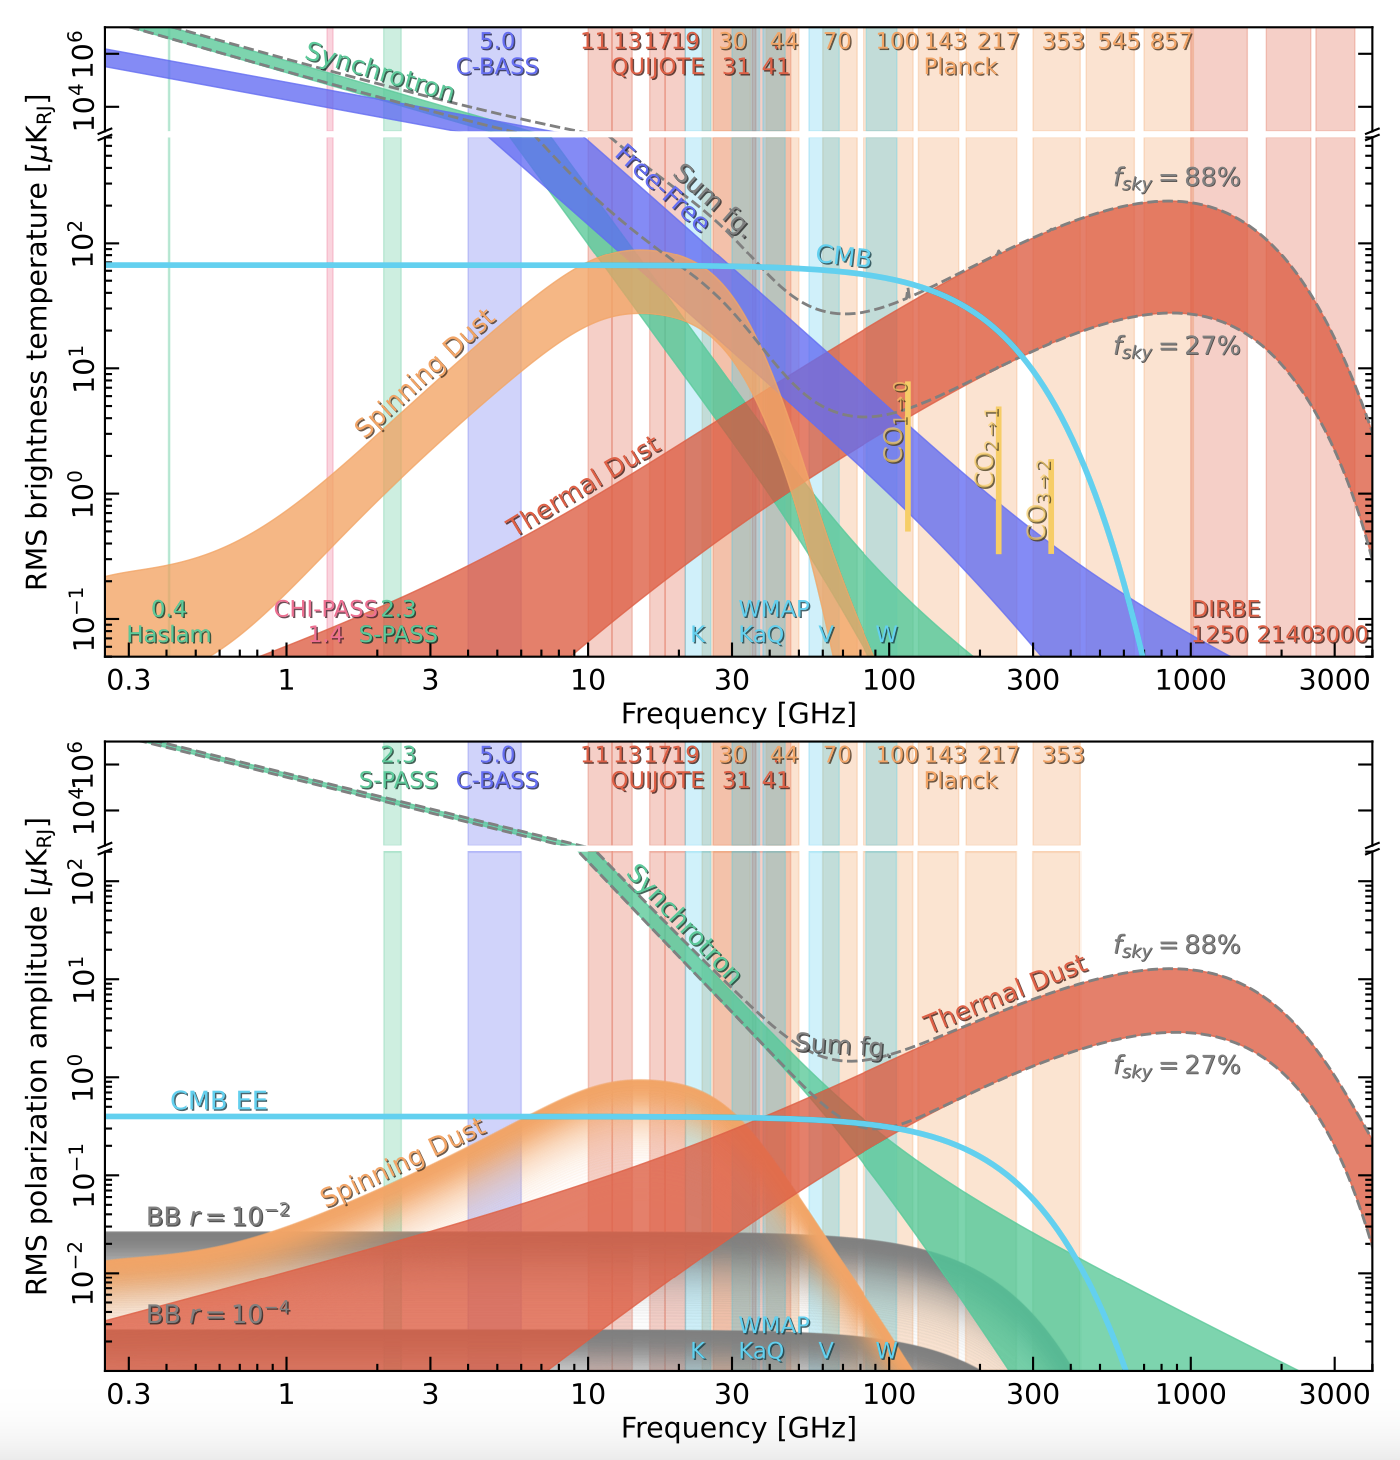

This figure provides an overview of the frequency dependence of spinning dust, synchrotron, free-free, thermal dust, and CMB. The CMB curve represents CMB fluctuations evaluated for the best-fit Planck ΛCDM spectrum [arXiv:2011.05609](https://arxiv.org/abs/2011.05609).

From Eq. (9) and (10), the relation between the thermodynamic temperature assuming differential blackbody and power law is
$$
T_C^*(\text{power law})=T_C^*(\text{differential blackbody})\cdot\left[\frac{1}{\nu_*^2g(\nu_*)}\frac{\int g(\nu)\nu^2f(\nu)d\nu}{\int (\nu/\nu_*)^\alpha f(\nu)d\nu}\right]
$$
and the theoretical color correction factor from differential blackbody to power law is
$$
cc_\mathrm{theo} = \frac{1}{\nu_*^2g(\nu_*)}\frac{\int g(\nu)\nu^2f(\nu)d\nu}{\int (\nu/\nu_*)^\alpha f(\nu)d\nu}
$$

Therefore, to compute the color correction factor, one needs to know the two SEDs and the bandpass. This is possible, but in reality, people use approximations.

---

### Thermodynamic-to-antenna temperature conversion factor
Finally, considering both unit conversion and color correction, the thermodynamic temperature is converted to antenna temperature by:
$$
\tag{11}
T_A^*=T_C^*\cdot g(\nu_*) \cdot cc
$$
where $g(\nu_*)$ converts the unit from thermodynamic to Rayleigh-Jeans at frequency $\nu_*$, and $cc$ is the color correction factor. Usually $cc$ is used to correct from differential blackbody to SED of other astrophysical/cosmological sources.